<a href="https://colab.research.google.com/github/forestsheart/NPL-to-automate-responses-email/blob/main/Automatic%20response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pdfplumber #leer pdfs
!pip install sodapy #extraer datos abiertos
!pip install unidecode #limpieza de texto
!pip install reportlab #libreria para crear pdfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.3 MB/s eta 0:00:00


In [2]:
#conexión a google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Montar Google Drive
from google.colab import drive as gdrive
#leer pdfs
import pdfplumber
#miselanius
import os
import pandas as pd


**Librerias para modelos maquinas de soporte vectorial**

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report


**Conexión con google Drive**

Se eligio google drive debido al mecanismo de obtención de los datos, los cuales deben ser descargados de una plataforma 1 a 1

In [4]:
# Autenticación
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
gdrive.mount('/content/drive')


Mounted at /content/drive


**Extraemos el id de la carpeta que contiene los pdf**

In [5]:
# Obtener el ID de una carpeta por su nombre
carpeta_nombre = 'Peticiones de entrada'
query = f"title = '{carpeta_nombre}' and mimeType = 'application/vnd.google-apps.folder' and trashed=false"
carpeta_lista = drive.ListFile({'q': query}).GetList()
if carpeta_lista:
    carpeta_id = carpeta_lista[0]['id']
    print(f'El ID de la carpeta "{carpeta_nombre}" es: {carpeta_id}')
else:
    print(f'No se encontró una carpeta con el nombre "{carpeta_nombre}"')


El ID de la carpeta "Peticiones de entrada" es: 1zlL_BkNAC0UW27pI1Hihg7of6_HAS5No


**Extraemos texto de  los pdfs en la carpeta**

In [ ]:
# Ruta de la carpeta en tu Google Drive
carpeta_id = carpeta_id
# Obtener lista de archivos en la carpeta
archivos = drive.ListFile({'q': f"'{carpeta_id}' in parents and trashed=false"}).GetList()

# Crear un DataFrame para almacenar los resultados
df_resultados = pd.DataFrame(columns=['Nombre del Archivo', 'Texto'])

# Leer los PDFs
for archivo in archivos:
    if archivo['title'].endswith('.pdf'):
        pdf_id = archivo['id']
        pdf_nombre = archivo['title']

        # Descargar el PDF
        pdf_path = os.path.join('/content/drive/My Drive/', pdf_nombre)
        archivo.GetContentFile(pdf_path)

        with pdfplumber.open(pdf_path) as pdf:
            texto = ''
            for pagina in pdf.pages:
                texto += pagina.extract_text()

        # Agregar los resultados al DataFrame
        df_resultados = df_resultados.append({'Nombre del Archivo': pdf_nombre[:-5], 'Texto': texto}, ignore_index=True)

        # Eliminar el PDF después de leerlo (opcional)
        os.remove(pdf_path)

# Mostrar el DataFrame con los resultados
print(df_resultados)


**Excluimos pdfs que no cumplen condiciones(Son imagenes)**

Esta exclusión se realiza para simplificar los procedimientos y debido a que un analisis y extracción de texto de imagenes se sale de los alcances de un algoritmo NER en texto

In [7]:
df_resultados=df_resultados[df_resultados['Texto'] != '']

In [8]:
df_resultados

,Nombre del Archivo,Texto
0,2023E1023525,"RESPUESTA CEPD 800830147441823008 , 6800830147..."
1,2023E1010149,*00092694*\nAl contestar cite Radicado 2023-2-...
2,2022E1046913,"Bogotá D.C., 29 de noviembre de 2022 2022\nDoc..."
3,2022E1038056,"EXT22-00082864\nNlr. 817.001.328-9\nTotoró, 23..."
4,2023E1026491,RV: SOLICITUD MEDIDA DE SUSPENSIÓN PROVISIONAL...
...,...,...
510,2022E1050758,Denuncia delito ambiental parque Barrio Marsel...
511,2022E1050550,Instituto Colombiano de Bienestar Familiar\nCe...
512,2022E1050689,"29/12/22, 15:31 Correo: Servicio al Ciudadano ..."
513,2022E1050540,"Calle 35 No. 7-25 Piso 7\nBogotá D.C., Colombi..."


**Cargamos las entidades a buscar dentro de los pdf(Departamentos)**
Elegimos departamentos con entidades a buscar dentro de el texto debido a la relación geoespacial con los entidades a las cuales se realiza el traslado.

In [9]:
import pandas as pd
from sodapy import Socrata#conecion a datos abiertos
client = Socrata("www.datos.gov.co", None)
results = client.get("xdk5-pm3f", limit=2000)
# Convert to pandas DataFrame
municipio= pd.DataFrame.from_records(results)

**Limpieza textos:**
En esta sección eliminaremos tildes, reemplazaremos mayusculas con minusculas

In [10]:
import pandas as pd
from unidecode import unidecode
#eliminamos caracteres especiales
def limpiar_texto(texto):
    return unidecode(texto)
#quitar puntos, comas, tildes

#municipio['municipio'] = municipio['municipio'].apply(limpiar_texto)
municipio['departamento'] = municipio['departamento'].apply(limpiar_texto)
df_resultados['Texto']=df_resultados['Texto'].apply(limpiar_texto)
#solo nos quedamos con las letras
import re
df_resultados['Texto'] = df_resultados['Texto'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

#cambiamos mayusculas por minusculas
municipio['departamento'] = municipio['departamento'].str.lower()
df_resultados['Texto']=df_resultados['Texto'].str.lower()


#quitamos la frase de bogota
df_resultados['Texto']=df_resultados['Texto'].str.replace(r'de\s+bogot[aá]\b', '', regex=True)

**Definimos función para encontrar entidades**

In [11]:
#convertimos a lista para manejo
departamento=municipio['departamento'].tolist()

def encontrar_departamento(texto):
    for palabra in departamento:
        # Usamos re.search() con una expresión regular que busca la palabra (ignorando mayúsculas y minúsculas)
        if re.search(r'\b{}\b'.format(re.escape(palabra)), texto, flags=re.IGNORECASE):
            return palabra
    return None


**Definimos función para encontrar entidad de manejo especial BOGOTA**

In [12]:
from pickle import NONE
import pandas as pd

def encontrar_bogota(texto, palabra):
    # Dividir el texto en palabras
    palabras = texto.split()
    # Iterar sobre las palabras
    for palabra_texto in palabras:
        # Revisar si la palabra objetivo está contenida en la palabra del texto
        if palabra.lower() in palabra_texto.lower():
            return palabra
    return None

**Aplicamos funciones para encontrar entidades(departamentos)**

In [13]:
df_resultados['departamento'] = df_resultados['Texto'].apply(encontrar_departamento)
# Aplica la función a la columna 'texto' y crea una nueva columna 'encontrada'
df_resultados['departamento_1'] = df_resultados['Texto'].apply(lambda x: encontrar_bogota(x, 'bogota'))

# Llena los valores NA en 'departamento' con los valores de 'departamento_1'
df_resultados['departamento'].fillna(df_resultados['departamento_1'], inplace=True)
#df_resultados

**buscamos la entidad departamento usando como proxy la entidad municipio** es decir, buscaremos el municipio en cada texto y si encontramos ese municipio buscamos el departamento al que ese municipio pertenece

In [ ]:
# Seleccionar las columnas 'municipio' y renombrar 'departamento' a 'departamento_2'
municipio = municipio[['municipio', 'departamento']].rename(columns={'departamento': 'departamento_2'})

In [ ]:
municipio['municipio'] = municipio['municipio'].apply(limpiar_texto)
#quitamos mayusculas
municipio['municipio'] = municipio['municipio'].str.lower()
# Aplicar la función str.replace para quitar 'D.C' de la columna 'Texto'
municipio['municipio'] = municipio['municipio'].str.replace(r'\bD\.C\b', '', regex=True)

In [ ]:
municipios = municipio['municipio'].tolist()
#encontrar municipio
def encontrar_municipio(texto):
    for palabra in municipios:
        # Usamos re.search() con una expresión regular que busca la palabra (ignorando mayúsculas y minúsculas)
        if re.search(r'\b{}\b'.format(re.escape(palabra)), texto, flags=re.IGNORECASE):
            return palabra
    return None

In [ ]:
# Aplicamos la función a la columna 'b' de B para obtener la columna 'c'
df_resultados['municipio'] = df_resultados['Texto'].apply(encontrar_municipio)

In [ ]:
df_resultados

In [ ]:
df_resultados.isna().sum()

**Unimos los municipios a nuestras peticiones de entrada**

In [ ]:
df_resultados=pd.merge(df_resultados, municipio, on='municipio', how='left')

**Si tenemos municipio pero no departamento tomamos el departamento del municipio**

In [21]:
# Llena los valores NA en 'departamento' con los valores de 'departamento_1'
df_resultados['departamento'].fillna(df_resultados['departamento_2'], inplace=True)

In [ ]:
df_resultados=df_resultados[df_resultados['departamento'] != None]

In [ ]:
df_resultados=df_resultados[df_resultados['departamento'].notna()]

**De las 353 peticiones de entrada encontramos departamento para 318**

In [24]:
len(df_resultados['Nombre del Archivo'].unique())

404

In [25]:
df_resultados = df_resultados[['Nombre del Archivo', 'departamento','Texto']]

In [26]:
# Leer el archivo Excel
control_salida_2022 = pd.ExcelFile('/content/drive/MyDrive/Traslados por competencia/CONTROL DE TRASLADOS 2022.xlsx')


**traemos las entidades de salida**

In [ ]:
# Columnas que deseas buscar
columna_1 = 'NUMERO DE RADICADO DE ENTRADA'   # Cambia 'Nombre' por el nombre de tu primera columna
#columna_2 = 'GRUPO DE ENTIDAD'
columna_3 = 'ENTIDAD DE TRASLADO '

#########2022
control_salida_2022_df = []

# Iterar sobre las hojas y buscar los valores
for sheet_name in control_salida_2022.sheet_names:
    df = pd.read_excel(control_salida_2022, sheet_name)
    control_salida_2022_df.extend(df[[columna_1,# columna_2,
                                      columna_3]].values.tolist())

# Crear un nuevo DataFrame con los resultados
control_salida_2022_df = pd.DataFrame(control_salida_2022_df, columns=[columna_1, columna_3])

control_salida_2022_df['NUMERO DE RADICADO DE ENTRADA']=control_salida_2022_df['NUMERO DE RADICADO DE ENTRADA'].str.split().str[0]#.unique()

patrones = ['ciudadano', 'señores','ciudadanos']

# Crear un patrón regex que coincida con cualquier variación de los patrones en la lista
patron_regex = '|'.join(r'\b{}\b'.format(re.escape(patron)) for patron in patrones)

# Filtrar el DataFrame usando el patrón regex
control_salida_2022_df = control_salida_2022_df[~control_salida_2022_df['ENTIDAD DE TRASLADO '].str.contains(patron_regex, case=False, na=False)]
control_salida_2022_df ['NUMERO DE RADICADO DE ENTRADA'] = control_salida_2022_df ['NUMERO DE RADICADO DE ENTRADA'] .str.replace(',', '')

control_salida_2022_df=control_salida_2022_df.drop_duplicates()


In [28]:
control_salida_2023 = pd.ExcelFile('/content/drive/MyDrive/Traslados por competencia/CONTROL DE SALIDA DE TRASLADOS  2023.xlsx')
# Columnas que deseas buscar
columna_1 = 'NUMERO DE RADICADO DE ENTRADA'   # Cambia 'Nombre' por el nombre de tu primera columna
#columna_2 = 'GRUPO DE ENTIDAD'
columna_3 = 'ENTIDAD DE TRASLADO '
#creamos df
control_salida_2023_df = []

# Iterar sobre las hojas y buscar los valores

for sheet_name in ['ENE - FEB','MARZ - ABRI','MAY - JUN']:
   try:
      df = pd.read_excel(control_salida_2023, sheet_name#,header=1
                         )
      control_salida_2023_df.extend(df[[columna_1,# columna_2,
                                      columna_3]].values.tolist())
   except:
           pass

# Crear un nuevo DataFrame con los resultados
control_salida_2023_df = pd.DataFrame(control_salida_2023_df, columns=[columna_1, columna_3])

#control_salida_2023_df['NUMERO DE RADICADO DE ENTRADA']=control_salida_2022_df['NUMERO DE RADICADO DE ENTRADA'].str.split().str[0]#.unique()

patrones = ['ciudadano', 'señores','ciudadanos']

# Crear un patrón regex que coincida con cualquier variación de los patrones en la lista
patron_regex = '|'.join(r'\b{}\b'.format(re.escape(patron)) for patron in patrones)

# Filtrar el DataFrame usando el patrón regex
control_salida_2023_df = control_salida_2023_df[~control_salida_2023_df['ENTIDAD DE TRASLADO '].str.contains(patron_regex, case=False, na=False)]
#control_salida_2023_df ['NUMERO DE RADICADO DE ENTRADA'] = control_salida_2023_df ['NUMERO DE RADICADO DE ENTRADA'] .str.replace(',', '')
#eliminar duplicadors
control_salida_2023_df=control_salida_2023_df.drop_duplicates()


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [ ]:
# Concatenar verticalmente los DataFrames
control_salida_df = pd.concat([control_salida_2022_df, control_salida_2023_df], axis=0)

# Reiniciar los índices si es necesario
control_salida_df = control_salida_df.reset_index(drop=True)

In [ ]:
control_salida_df= control_salida_df[control_salida_df['NUMERO DE RADICADO DE ENTRADA'].notna()]

In [ ]:
control_salida_df['ENTIDAD DE TRASLADO '].nunique()#.value_counts())

In [ ]:
df_resultados['NUMERO DE RADICADO DE ENTRADA']=df_resultados['Nombre del Archivo']

In [ ]:
df_resultados=pd.merge(df_resultados, control_salida_df, on='NUMERO DE RADICADO DE ENTRADA', how='left')

In [ ]:
df_resultados['ENTIDAD DE TRASLADO '].nunique()#.value_counts())

In [ ]:
df_resultados=df_resultados.drop_duplicates(subset=['Nombre del Archivo', 'ENTIDAD DE TRASLADO '])#.isna().sum()

In [ ]:
df_resultados

In [37]:
df_resultados=df_resultados[df_resultados['ENTIDAD DE TRASLADO '].notna()]

**A partir de aqui empezamos a la deteción de la entidad a la cual trasladar**
primero nos quedamos con las solicitudes de las 4 entidades de interes

In [38]:
import pandas as pd
import re

# nos quedamos con las corporaciones autonomas, secretaria de ambiente, parques nacionales, autoridad nacional
regex_pattern = r'Corporación Autónoma|Secretaría|Parques Nacionales|Autoridad Nacional'
filtered_df = df_resultados[df_resultados['ENTIDAD DE TRASLADO '].str.contains(regex_pattern, flags=re.IGNORECASE, regex=True,na=False)]
#eliminamos duplicados
filtered_df=filtered_df.drop_duplicates()
filtered_df

,Nombre del Archivo,departamento,Texto,NUMERO DE RADICADO DE ENTRADA,ENTIDAD DE TRASLADO
1,2023E1010149,cauca,\nal contestar cite radicado id \nf o l i o s...,2023E1010149,Corporación Autónoma Regional del Cauca - CRC
2,2023E1010149,cauca,\nal contestar cite radicado id \nf o l i o s...,2023E1010149,Parques Nacionales Naturales de Colombia - PNNC
3,2022E1046913,boyaca,bogota dc de noviembre de \ndoctora\nirene v...,2022E1046913,Autoridad Nacional de Licencias Ambientales – ...
4,2022E1046913,boyaca,bogota dc de noviembre de \ndoctora\nirene v...,2022E1046913,Corporación Autónoma Regional de Boyacá – CORP...
12,2023E1026491,cordoba,rv solicitud medida de suspension provisional ...,2023E1026491,Autoridad Nacional de Licencias Ambientales ANLA
...,...,...,...,...,...
876,2022E1050800,bogota,radicado ndeg e\n folios na web anexos \n...,2022E1050800,Corporación Autónoma Regional de la Frontera N...
877,2022E1050659,bogota,ofi gfpu\nbogota dc de diciembre de \nofi g...,2022E1050659,Autoridad Nacional de Licencias Ambientales ANLA
882,2022E1050808,cesar,ofi gfpu\nbogota dc de diciembre de \nofi g...,2022E1050808,Corporación Autónoma Regional del Alto Magdale...
891,2022E1050540,meta,calle no piso \nbogota dc colombia\npbx \nw...,2022E1050540,Autoridad Nacional de Licencias Ambientales ANLA


In [39]:
#Aqui podemos observar la cantidad de solicitudes con las que se hizo el analisis
len(filtered_df['Nombre del Archivo'].unique())

261

**Creamos las funciones para eliminar stop words y tokenizar**

In [40]:
#función remover stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  # Descargar las stopwords en español (si aún no lo has hecho)

def remove_stopwords(text):
    # Obtener el conjunto de stopwords en español
    spanish_stopwords = set(stopwords.words('spanish'))

    # Dividir el texto en palabras
    words = text.split()

    # Filtrar las palabras para quitar las stopwords
    filtered_words = [word for word in words if word.lower() not in spanish_stopwords]

    # Unir las palabras filtradas en un texto nuevamente
    filtered_text = ' '.join(filtered_words)

    return filtered_text



#función limpiar y tokenizar
def limpiar_tokenizar(texto):

    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de palabras speaker
    nuevo_texto = re.sub('speaker+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\\\?\\¿]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales

    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 3]

    return(nuevo_texto)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Limpieza adicional del texto de cada pdf

In [ ]:
#eliominar numeros
filtered_df['Texto'] = filtered_df['Texto'].str.replace(r'\d+', '',regex=True)

#remover stop words
filtered_df["Texto"]=filtered_df['Texto'].apply(lambda x:remove_stopwords(str(x)))
####limpiar y tokenizar
filtered_df["Texto"]=filtered_df['Texto'].apply(lambda x:limpiar_tokenizar(str(x)))

**Acontinuaciónn crearemos las categorias que utilizaremos como variable respuesta en el modelo** se seleccionaron 3 entindades, secretaria de ambiente, autoridad nacional de licencias y parques nacionales, así como se tomo como 1 misma categoria todas las corporaciones autonomas regionales

In [42]:
import pandas as pd
import numpy as np

# Suponiendo que df es tu DataFrame en Python y columna es la columna en la que quieres aplicar la condición

condiciones = [
    filtered_df['ENTIDAD DE TRASLADO '].str.contains("Corporación Autónoma"),
    filtered_df['ENTIDAD DE TRASLADO '].str.contains("Secretaría"),
    filtered_df['ENTIDAD DE TRASLADO '].str.contains("Parques Nacionales"),
    filtered_df['ENTIDAD DE TRASLADO '].str.contains("Autoridad Nacional")
]



opciones = ['Ambiente', 'Ambiente','Parques', 'Autoridad']

# Crea la nueva columna 'categoria' usando np.select()
filtered_df['categoria'] = np.select(condiciones, opciones, default=None)

#filtered_df


In [43]:
#Volvemos a eliminar duplicados
filtered_df=filtered_df.drop_duplicates(subset=['Nombre del Archivo', 'categoria'])#.isna().sum()
filtered_df

,Nombre del Archivo,departamento,Texto,NUMERO DE RADICADO DE ENTRADA,ENTIDAD DE TRASLADO,categoria
1,2023E1010149,cauca,"[contestar, cite, radicado, fecha, anexos, sop...",2023E1010149,Corporación Autónoma Regional del Cauca - CRC,Ambiente
2,2023E1010149,cauca,"[contestar, cite, radicado, fecha, anexos, sop...",2023E1010149,Parques Nacionales Naturales de Colombia - PNNC,Parques
3,2022E1046913,boyaca,"[bogota, noviembre, doctora, irene, velez, tor...",2022E1046913,Autoridad Nacional de Licencias Ambientales – ...,Autoridad
4,2022E1046913,boyaca,"[bogota, noviembre, doctora, irene, velez, tor...",2022E1046913,Corporación Autónoma Regional de Boyacá – CORP...,Ambiente
12,2023E1026491,cordoba,"[solicitud, medida, suspension, provisional, a...",2023E1026491,Autoridad Nacional de Licencias Ambientales ANLA,Autoridad
...,...,...,...,...,...,...
876,2022E1050800,bogota,"[radicado, ndeg, folios, anexos, destino, remd...",2022E1050800,Corporación Autónoma Regional de la Frontera N...,Ambiente
877,2022E1050659,bogota,"[gfpu, bogota, diciembre, gfpu, cite, numero, ...",2022E1050659,Autoridad Nacional de Licencias Ambientales ANLA,Autoridad
882,2022E1050808,cesar,"[gfpu, bogota, diciembre, gfpu, cite, numero, ...",2022E1050808,Corporación Autónoma Regional del Alto Magdale...,Ambiente
891,2022E1050540,meta,"[calle, piso, bogota, colombia, wwwanteagroupc...",2022E1050540,Autoridad Nacional de Licencias Ambientales ANLA,Autoridad


In [44]:
#eliminamos los na de la categorización realizada
filtered_df=filtered_df[filtered_df['categoria'].notna()]
filtered_df= filtered_df.reset_index(drop=True)

In [45]:
#separamos nuestra muestra de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(filtered_df['Texto'], filtered_df['categoria'], test_size=0.2, random_state=42)
X_test_P=X_test

In [46]:
# Acceder a los índices originales de los conjuntos de entrenamiento y prueba
indices_train = X_train.index
indices_test = X_test.index


In [47]:
# Supongamos que cada elemento de X_train y X_test es una lista de texto
X_train = [' '.join(text_list) for text_list in X_train]
X_test = [' '.join(text_list) for text_list in X_test]
#vectorizamos nuestra muestra
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)



**Modelos maquinas de soporte vectorial**

In [48]:
#calculamos modelo
import random
random.seed(24) #semilla aleatoria para resultados replicables
clf = SVC(kernel='linear', C=1)
clf.fit(X_train_vec, y_train)


SVC(C=1, kernel='linear')

**Predicciones del modelo**

In [49]:
y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Ambiente       0.64      0.81      0.71        31
   Autoridad       0.75      0.60      0.67        15
     Parques       0.43      0.25      0.32        12

    accuracy                           0.64        58
   macro avg       0.61      0.55      0.57        58
weighted avg       0.63      0.64      0.62        58



tomaremos todas las predicciones para generar los pdfs

In [50]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_vec, y_train, cv=5)
average_accuracy = scores.mean()
average_accuracy

0.5739130434782609

**Matriz de confusión**

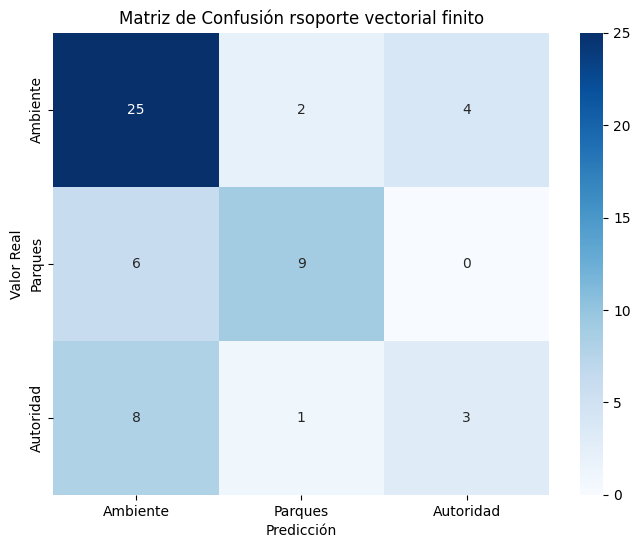

In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
confusion = confusion_matrix(y_test, y_pred)
labels = ['Ambiente', 'Parques',"Autoridad"]

# Paso 7: Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión rsoporte vectorial finito')
plt.show()

**modelo random forest**

In [52]:
from sklearn.ensemble import RandomForestClassifier
random.seed(24)
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_test_vec)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Ambiente       0.63      0.77      0.70        31
   Autoridad       0.69      0.60      0.64        15
     Parques       0.43      0.25      0.32        12

    accuracy                           0.62        58
   macro avg       0.58      0.54      0.55        58
weighted avg       0.61      0.62      0.60        58



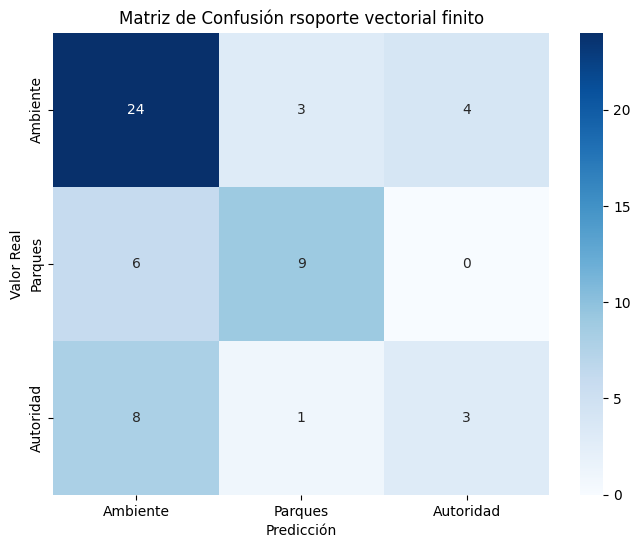

In [55]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
confusion = confusion_matrix(y_test, y_pred)
labels = ['Ambiente', 'Parques',"Autoridad"]

# Paso 7: Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión rsoporte vectorial finito')
plt.show()

**Modelos redes neuronales lstm**

In [56]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [ ]:
# Paso 4: Preprocesar los datos de texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [58]:
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

In [59]:
# Paso 5: Codificar la variable objetivo
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [60]:
# Paso 6: Crear el modelo de red neuronal LSTM
# Configurar la semilla para TensorFlow
import tensorflow as tf
tf.random.set_seed(24)
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [61]:
# Paso 7: Compilar y ajustar el modelo
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.fit(X_train_padded, y_train_encoded, validation_data=(X_test_padded, y_test_encoded), epochs=10, batch_size=16)

**Nos quedamos unicamente con los elementos de testeo es decir las predicciones**

**tomaremos todas las entidades de taslado conjunto de entrenamiento y prueba**

In [62]:
#calcularemos la entidad de traslado:
# Obtener valores únicos de las columnas entidad de traslado y departamento unicamente para el caso de corporaciones autonomas
departamento_entidad = filtered_df[filtered_df['categoria'] == 'Ambiente'][['departamento', 'ENTIDAD DE TRASLADO ']].drop_duplicates()
departamento_entidad['ENTIDAD PREDICCION'] = departamento_entidad['ENTIDAD DE TRASLADO ']
departamento_entidad = departamento_entidad[['ENTIDAD PREDICCION', 'departamento']]
condicion = ~((departamento_entidad['departamento'] == 'bogota') & (departamento_entidad['ENTIDAD PREDICCION'] != 'Secretaría Distrital de Ambiente'))
departamento_entidad = departamento_entidad[condicion]

In [63]:
departamento_entidad

,ENTIDAD PREDICCION,departamento
0,Corporación Autónoma Regional del Cauca - CRC,cauca
3,Corporación Autónoma Regional de Boyacá – CORP...,boyaca
5,Corporación Autónoma Regional de los Valles de...,cordoba
11,Corporación Autónoma Regional del Magdalena - ...,magdalena
14,Corporación Autónoma Regional de la Frontera N...,santander
...,...,...
271,Corporación Autónoma Regional del Cauca CRC,santander
278,Corporación Autónoma Regional de la Guajira -...,la guajira
279,Corporación Autónoma Regional del Caldas CORPO...,caldas
280,Corporación Autónoma Regional de la Guajira CO...,la guajira


Ahora unimos las entidades encontradas con nuestros elementos de testeo

In [64]:
#tomamos los elementos originales del data frame con el que hicimos las predicciones
elementos_test = filtered_df.loc[X_test_P.index]
#para las predicciones nos quedamos con los elementos de el modelo de maquinas de soporte vectorial
y_pred = clf.predict(X_test_vec)
#unimos las predicciones a nuestro datframe de entrada
elementos_test['prediccion']=y_pred
# Reiniciar los índices para poder unir despues
elementos_test = elementos_test.reset_index(drop=True)
#3unimos la entidad de traslado a nuestro dataframe de pruebas
elementos_test = pd.merge(elementos_test, departamento_entidad, on=['departamento'], how='left')


Ahora de acuerdo a la categorización previamente hecha recuperamos la entidad tomando la preddicón y el departamento

In [65]:
#en este chunck colocaremos la entidad de traslado correspondiente de acuerdo a la predicción obtenida
condiciones = [
    (elementos_test['prediccion'] == 'Autoridad'),
    (elementos_test['prediccion'] == 'Parques' ),
    (~elementos_test['prediccion'].isin(['Parques' , 'Autoridad']))
]

valores = ['Autoridad Nacional de Licencias Ambientales ANLA', 'Parques nacionales naturales de Colombia', elementos_test['ENTIDAD PREDICCION']]

# Utilizar numpy.select para aplicar las condiciones
elementos_test['ENTIDAD PREDICCION'] = np.select(condiciones, valores, default=elementos_test['ENTIDAD PREDICCION'])




In [66]:
#eliminamos elementos que no tienen predicicón
elementos_test=elementos_test[elementos_test['ENTIDAD PREDICCION'].notna()]

Empezaremos a crear la plantilla del pdf de salida del ciudadano y de la entidad

In [67]:
#primera fila
from datetime import datetime
# Obtener la fecha actual en formato YYYY-MM-DD
fecha_actual = datetime.today().strftime('%Y-%m-%d')
# Concatenar "Bogota DC" y la fecha actual
resultado = "Bogota DC " + fecha_actual
# Mostrar el resultado
print(resultado)
elementos_test["ciudad_fecha"]=resultado
elementos_test["info_entidad"]=str("Nombre:")+elementos_test['ENTIDAD PREDICCION']+str("\n"+"Pagina web:www........\nTelefono\nCorreo electronico:\nDireccion\nHorrario Atención:Lunes a viernes de 8:00 a.m. a 5:30 p.m.")
elementos_test["info_funcionario"]="Coordialmente\n\n\n\n\n\nNombre funcionario\nCargo funcionario"
elementos_test["info_director_entidad"]=str("Señor\nNombre Funcionario\nDirector\n")+elementos_test['ENTIDAD PREDICCION']+"\nCorreo funcionario\n "
elementos_test["Asunto_entidad"]="Asunto:Traslado del Radicado No."+elementos_test["NUMERO DE RADICADO DE ENTRADA"]
#parrafo generico 1
elementos_test["parrafo_E0"]="Cordial saludo\n \nEl Ministerio de Ambiente y Desarrollo Sostenible informa que, de conformidad \ncon lo dispuesto en el Ley 1755 de 2015, Articulo 21, se traslada por competencia a \n"+elementos_test['ENTIDAD PREDICCION']+  ",la petición\ninterpuesta por el remitente del radicado para tratar los temas del adjunto \n"
#parrafo generico 2
elementos_test["parrafo_E1"]="La solicitud interpuesta por el peticionario no es competencia de este Ministerio,\nconforme lo establecido en el Decreto 3570 de 2011, que asignó a la Entidad\nla función de definir la política Nacional Ambiental y promover la recuperación,\nconservación, protección, ordenamiento,manejo, uso y aprovechamiento de los\nrecursos naturales renovables, a fin de asegurar el desarrollo sostenible\ny garantizar el derecho de todos los ciudadanos a gozar y heredar un ambiente sano. "
#parrafo autoridad
elementos_test["parrafo_E2A"]="El traslado se realiza en atención a las funciones y competencias del Autoridad Nacional\nde Licencias Ambientales - ANLA, entidad encargada de los proyectos, obras \no actividades sujetos de licenciamiento, permiso o trámite ambiental cumplan \ncon la normativa ambiental, de tal manera que contribuyan al desarrollo sostenible\n ambiental del País."
#parrafo parque
elementos_test["parrafo_E2P"]="Este traslado se realiza en atención a las funciones y competencias de Parques Nacionales \nNaturales de Colombia - PNNC, entidad encargada de administrar y Manejar las \náreas a cargo de Parques Nacionales Naturales y coordinar el Sistema Nacional \nde Áreas Protegidas (SINAP) de Colombia, promoviendo la participación de diversos\nactores, con el propósito de conservar la diversidad biológica y cultural del país, \ncontribuyendo al desarrollo sostenible y a un medio ambiente sano."
#parrafo corporación
elementos_test["parrafo_E2C"]="El traslado se realiza en atención a las funciones y competencias de \n"+elementos_test['ENTIDAD PREDICCION']+ ", entidad\n“responsable de ejecutar las políticas, planes,programas y proyectos sobre medio\nambiente y recursos naturales renovables, así como dar cumplida y oportuna\naplicación a las disposiciones legales vigentes sobre su disposición, administración, manejo\ny aprovechamiento, conforme a las regulaciones, pautas y directrices expedidas por\nel Ministerio del Medio Ambiente”."
#parrafo secreytaria
elementos_test["parrafo_E2S"]="Este traslado se realiza en atención a las funciones y competencias de la Secretaría \nDistrital de Ambiente - SDA, entidad encargada “como autoridad ambiental del Distrito \nCapital propender por el desarrollo sostenible de la ciudad, formulando promoviendo y \norientando políticas, planes y programas que permitan la conservación, protección y \nrecuperación del ambiente y de los bienes y servicios naturales de la Estructura Ecológica \nPrincipal y de las áreas de interés ambiental; para mejorar su calidad de vida, la relación\nentre la población y el entorno natural, el disfrute de los derechos fundamentales\ny colectivos del ambiente, respondiendo a las acciones encaminadas a  la adaptación y\nmitigación al cambio climático,reverdeciendo a Bogotá y promoviendo la participación de\nla ciudadanía en todas sus dimensiones y el cambio de los hábitos de vida”."
#parrafor generico 4
elementos_test["parrafo_E3"]="En atención al marco legal, el Ministerio solicita remitir respuesta de fondo al/los ciudadanos/s\na quien estamos informando de la presente actuación, y dentro de los \ntérminos de colaboración entre autoridades se solicita remitir copia de la respuesta\na este Ministerio, citando el radicado del asunto."
#info ciudadano
elementos_test["Info_ciudadano"]="Acontinuación, se relacion los datos del peticionario\n\nNombre:\nDirección:\nCorreo electronico:\nDepartamento:"



Bogota DC 2023-11-14


In [68]:
import pandas as pd
import numpy as np
# condiones para definir el parrafo 3
condiciones = [
    elementos_test['ENTIDAD PREDICCION'].str.contains("Corporación"),
    elementos_test['ENTIDAD PREDICCION'].str.contains("Secretaría"),
    elementos_test['ENTIDAD PREDICCION'].str.contains("Parques"),
    elementos_test['ENTIDAD PREDICCION'].str.contains("Autoridad")
]
#parrafo seleccionado
opciones = [elementos_test["parrafo_E2C"], elementos_test["parrafo_E2S"],elementos_test["parrafo_E2P"], elementos_test["parrafo_E2A"]]
# Crea la nueva columna con parrafo 3
elementos_test['parrafo_E2'] = np.select(condiciones, opciones, default=None)

Creamos el pdf del la entidad a la que se traslada

In [69]:
p=32#petición de salida
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.utils import ImageReader
# Crear un nuevo archivo PDF
pdf_path = str("respuesta traslado radicado "+elementos_test.iloc[p,0]+".pdf")
c = canvas.Canvas(pdf_path, pagesize=letter)

# Configurar el tamaño de la fuente
font_size = 12
c.setFont("Helvetica", font_size)
# Definir la posición de la imagen
x, y = 80, 700
# Cargar la imagen
imagen_path = "/content/drive/MyDrive/Traslados por competencia/logo ministerio ambiente.png"  # Reemplaza con la ruta de tu imagen
imagen = ImageReader(imagen_path)

# Ajustar el tamaño de la imagen si es necesario
ancho, alto = 500, 80  # Puedes ajustar estos valores según tus necesidades

# Agregar la imagen al PDF
c.drawImage(imagen, x, y, width=ancho, height=alto)


# Definir las coordenadas iniciales para el texto
x, y = 80, 670

# Agregar texto bogota fecha
for line in elementos_test.iloc[p,8].split('\n'):
    c.drawString(x, y, line)
    y -= font_size + 2  # Separación entre líneas

# Agregar información director entidad
x, y = 80, 620
for line in elementos_test.iloc[p,11].split('\n'):
    c.drawString(x, y, line)
    y -= font_size + 2  # Separación entre líneas

# Agregar Asunto
x, y = 80, 520
for line in elementos_test.iloc[p,12].split('\n'):
    c.drawString(x, y, line)
    y -= font_size + 2  # Separación entre líneas

# Agregar parrafo
x, y = 80, 490
for line in elementos_test.iloc[p,13].split('\n'):
    c.drawString(x, y, line)
    y -= font_size + 2  # Separación entre líneas

# Agregar parrafo
x, y = 80, 400
for line in elementos_test.iloc[p,14].split('\n'):
    c.drawString(x, y, line)
    y -= font_size + 2  # Separación entre líneas



# Agregar parrafo
x, y = 80, 310
for line in elementos_test.iloc[p,21].split('\n'):
    c.drawString(x, y, line)
    y -= font_size + 2  # Separación entre líneas

# Definir la posición de la imagen
x, y = 80, 50
# Cargar la imagen
imagen_path = "/content/drive/MyDrive/Traslados por competencia/info ministerio ambiente.png"  # Reemplaza con la ruta de tu imagen
imagen = ImageReader(imagen_path)

# Ajustar el tamaño de la imagen si es necesario
ancho, alto = 500, 80  # Puedes ajustar estos valores según tus necesidades

# Agregar la imagen al PDF
c.drawImage(imagen, x, y, width=ancho, height=alto)

# Agregar una nueva página
c.showPage()
# Definir las coordenadas iniciales para el texto
# Definir la posición de la imagen
x, y = 80, 700
# Cargar la imagen
imagen_path = "/content/drive/MyDrive/Traslados por competencia/logo ministerio ambiente.png"  # Reemplaza con la ruta de tu imagen
imagen = ImageReader(imagen_path)

# Ajustar el tamaño de la imagen si es necesario
ancho, alto = 500, 80  # Puedes ajustar estos valores según tus necesidades

# Agregar la imagen al PDF
c.drawImage(imagen, x, y, width=ancho, height=alto)

x, y = 80, 670

# Agregar texto bogota fecha
for line in elementos_test.iloc[p,19].split('\n'):
    c.drawString(x, y, line)
    y -= font_size + 2  # Separación entre líneas

x, y = 80, 590

# Agregar texto bogota fecha
for line in elementos_test.iloc[p,20].split('\n'):
    c.drawString(x, y, line)
    y -= font_size + 2  # Separación entre líneas
# Agregar info funcionaria que envia
x, y = 80, 360
for line in elementos_test.iloc[p,10].split('\n'):
    c.drawString(x, y, line)
    y -= font_size + 2  # Separación entre líneas



# Definir la posición de la imagen
x, y = 80, 50
# Cargar la imagen
imagen_path = "/content/drive/MyDrive/Traslados por competencia/info ministerio ambiente.png"  # Reemplaza con la ruta de tu imagen
imagen = ImageReader(imagen_path)

# Ajustar el tamaño de la imagen si es necesario
ancho, alto = 500, 80  # Puedes ajustar estos valores según tus necesidades

# Agregar la imagen al PDF
c.drawImage(imagen, x, y, width=ancho, height=alto)

c.save()

print(f"El archivo PDF ha sido creado en: {pdf_path}")

El archivo PDF ha sido creado en: respuesta traslado radicado 2022E1045126.pdf


Empezaremos a crear el texto de salida